First lets get the imports out of the way: 

In [48]:
import pandas as pd
from prince import MCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib as mpl
import numpy as np
import plotly.express as px


Let's load the data:

In [49]:
df = pd.read_csv('./HealthCareAustralia.csv')
df

,sex,age,agesq,income,levyplus,freepoor,freepera,illness,actdays,hscore,chcond1,chcond2,doctorco,nondocco,hospadmi,hospdays,medicine,prescrib,nonpresc,constant
0,1,0.19,0.0361,0.55,1,0,0,1,4,1,0,0,1,0,0,0,1,1,0,1
1,1,0.19,0.0361,0.45,1,0,0,1,2,1,0,0,1,0,0,0,2,1,1,1
2,0,0.19,0.0361,0.90,0,0,0,3,0,0,0,0,1,0,1,4,2,1,1,1
3,0,0.19,0.0361,0.15,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
4,0,0.19,0.0361,0.45,0,0,0,2,5,1,1,0,1,0,0,0,3,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5185,1,0.22,0.0484,0.55,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5186,0,0.27,0.0729,1.30,0,0,0,0,0,1,0,0,0,0,0,0,3,0,3,1
5187,1,0.37,0.1369,0.25,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1
5188,1,0.52,0.2704,0.65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Parallel Coordinates Plot
Let's have a look at a parallel coordinates plot and see if 
there are any visible patterns in the data. Here I'm ignoring some 
columns, as I haven't found them very interesting in this plot. 

In [50]:
ignored_columns = ["agesq", "freepoor", "constant", "levyplus", 
                   "freepera", "chcond1", "chcond2", "medicine", 
                   "nonpresc", "hscore", "income", "sex"]
column_order = [
    "age", "illness", "nondocco", "actdays", "hospadmi", "hospdays",
    "prescrib", "doctorco"
]
px.parallel_coordinates(df.loc[:, [i for i in df.columns if i not in ignored_columns]], 
                        color="doctorco", dimensions=column_order)

From the plot above we can draw a few conclusions. The most surprising 
one for me is that people who visit the doctor a lot are not the same 
people who stay in the hospital a lot. It seems that cases with a high
number of doctors visits may have a relatively normal length hospital 
stay, after/before which they visit the doctor a lot. Interestingly, 
we can also see that a lot of people with a high number of doctors 
visits do get admitted to hospital at least once, if not multiple times.

Another observation is that all people with a high number of doctors 
visits have been sick at least once in the past 2 weeks. We also dont 
see any strong correlation between nondocco and doctorco which is 
interesting. Age also doesn't seem to be a huge factor, although there 
are more old people going to the doctor.

# Projecting the Data to 2 Dimensions
In order to visualise the dataset with a plot, we need to reduce the 
number of dimensions. I'll be using 2 methods for dimensionality 
reduction:

**PCA**:
PCA works very well for continuous data, but our dataset is all  
categorical variables, making PCA a little out of place.
It should however be interesting to see how it fares.

**MCA**:
MCA is basically PCA but for categorical data. It should work much better 
for the categorical variables we have, but we will have to cut out the 
continuous ones which could lose us some information.

For most of my analysis, I will be excluding doctors visits from the 
downprojection, and instead encoding it using color. This provides a way 
of analyzing how easy it may be to separate out high doctors visits from 
the rest of the data.

## Explaining MCA
Since we don't cover MCA in the course, I'll provide a short summary of 
how it works here.
MCA stands for "Multiple Correspondence Analysis", and is an extension 
of Correspondence Analysis.

The procedure of MCA is as follows:
1. Build an *indicator matrix* (one-hot encoding of the data)
2. Perform CA on the indicator matrix.

### Correspondence Analysis
I'll provide two explanations of how CA works in the context of MCA. 
One is the actual regular theory, while the other is based on PCA.
The regular procedure is as follows:
1. Let $N$ be the sum of all entries in our indicator matrix $X$.
2. $Z=\frac{X}{N}$ (We're basically normalizing the data).
3. Let $r$ be a vector containing the sums along the rows of $Z$, and 
   let $c$ be the sum along all columns of $Z$. 
4. With this, perform the decomposition: $M=diag(r)^{-\frac{1}{2}}(Z-rc^{T})diag(c)^{-\frac{1}{2}}$.
5. This gives you $M=P\Delta Q^{T}$.

I'm sure you can see the similarities with PCA. This is the PCA based 
explanation:
1. Let $y_{ik}$  be a value in the indicator matrix and let $p_{k}$ be 
   the sum of row $k$ in the indicator matrix.
2. We normalize the indicator matrix: $x_{ik}=y_{ik}/p_{k} - 1$
3. Apply unstandardized PCA to this matrix.

Both of these approaches have been proven equivalent.

## Down-projecting with PCA:
Here I simply use normalized PCA on the dataset while excluding doctors 
visits.

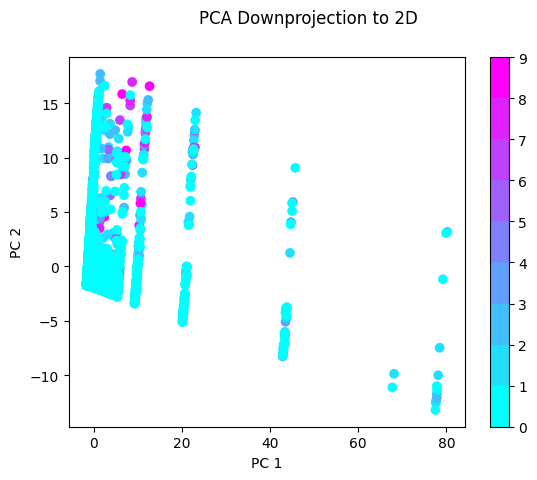

In [51]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df.loc[:, df.columns != "doctorco"])

hot = mpl.colormaps['cool'].resampled(9)
newcolors = hot(np.linspace(0, 1, 9))
newcmp = mpl.colors.ListedColormap(newcolors)

fig, ax = plt.subplots()
cb = ax.scatter(df_pca[:,0], df_pca[:,1], c=df['doctorco'], cmap=newcmp)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
fig.suptitle("PCA Downprojection to 2D")
fig.colorbar(cb)
plt.savefig("./pca_down_2d.png")
pass

The results aren't very good-looking, but we can clearly see that points 
with high amounts of doctors visits do stand out in some areas. It's 
clear however that PCA isn't really ment for catagorical data, so let's 
try MCA.

## Down-Projecting with MCA
Here I initially don't include doctors visits in the downprojection, but 
later I take a more exploratory look at the data where I do include it.

In [52]:
df_nodoctorco = df.loc[:, df.columns != "doctorco"]
mca = MCA(
    n_components=142,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(df_nodoctorco)
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.236,3.62%,3.62%
1,0.134,2.05%,5.67%
2,0.129,1.98%,7.64%
3,0.115,1.76%,9.41%
4,0.111,1.71%,11.11%
...,...,...,...
137,0.000,0.00%,100.00%
138,0.000,0.00%,100.00%
139,0.000,0.00%,100.00%


Looking at the % of variance, this doesn't look overly promising. We 
can visualize this better with a graph.

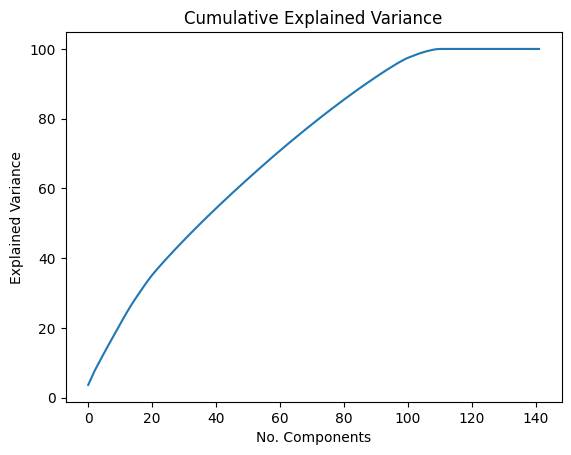

In [53]:
cumvariance = np.cumsum(mca.percentage_of_variance_)

fig, ax = plt.subplots()
ax.plot(range(len(cumvariance)), cumvariance)
ax.set_xlabel("No. Components")
ax.set_ylabel("Explained Variance")
ax.set_title("Cumulative Explained Variance")
plt.savefig("./mca_cumvar.png")
pass

MCA is clearly able to remove some of the obviously correlated 
dimensions such as age/agesq. However, there isn't any real elbow in 
the plot. This means that reducing the number of dimensions past the 
very correlated ones would lose information.

This is a little disappointing, however, if we were really looking to 
reduce the amount of dimensions, we could choose around the 20 mark 
where there is a slight bend in the curve.

### Visualizing MCA

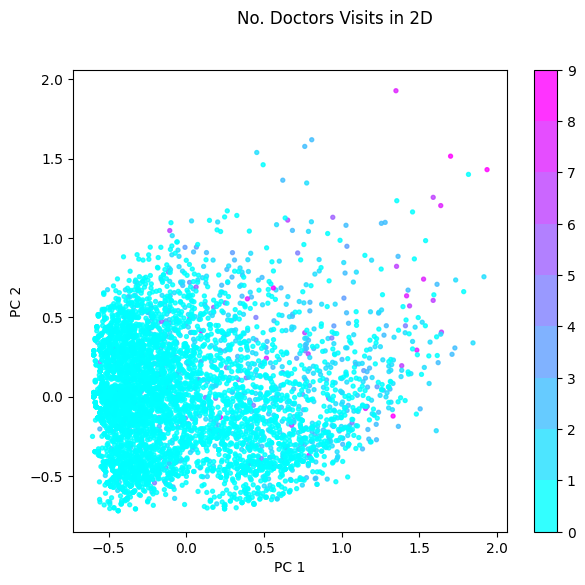

In [54]:
df_mca = mca.row_coordinates(df_nodoctorco).to_numpy()

alpha = 0.8  # Transparency of points
size = 8  # Size of points

fig, ax = plt.subplots(figsize=(7, 6))
cb = ax.scatter(
    df_mca[:,0], df_mca[:,1], 
    c=df['doctorco'], 
    alpha=alpha, 
    s=size, 
    cmap=newcmp
)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
fig.colorbar(cb)
fig.suptitle("No. Doctors Visits in 2D")
plt.savefig("./mca_doctors_2d.png")
pass

This already looks a lot better than PCA, although it's difficult to 
see exactly what's going on due to the overwhelming number of zero's.
Despite this, we can see that again the points with a high number of 
doctors visit's do stand out a little. 

### Looking at Different Principal Components
Different PC's capture different elements of the data. We can explore 
this by plotting them. Here we'll have a look at all combinations of the 
first 3 principal components, which capture about 7.64% percent of the 
variance of the data.

##### Under-sampling the Data
In order to aid in visualization, I've under-sampled all data by a 
factor of 2, and additionally under-sampled 0's and 1's by a factor of 10. 
This makes it much easier to see points with a high number of doctors 
visits.

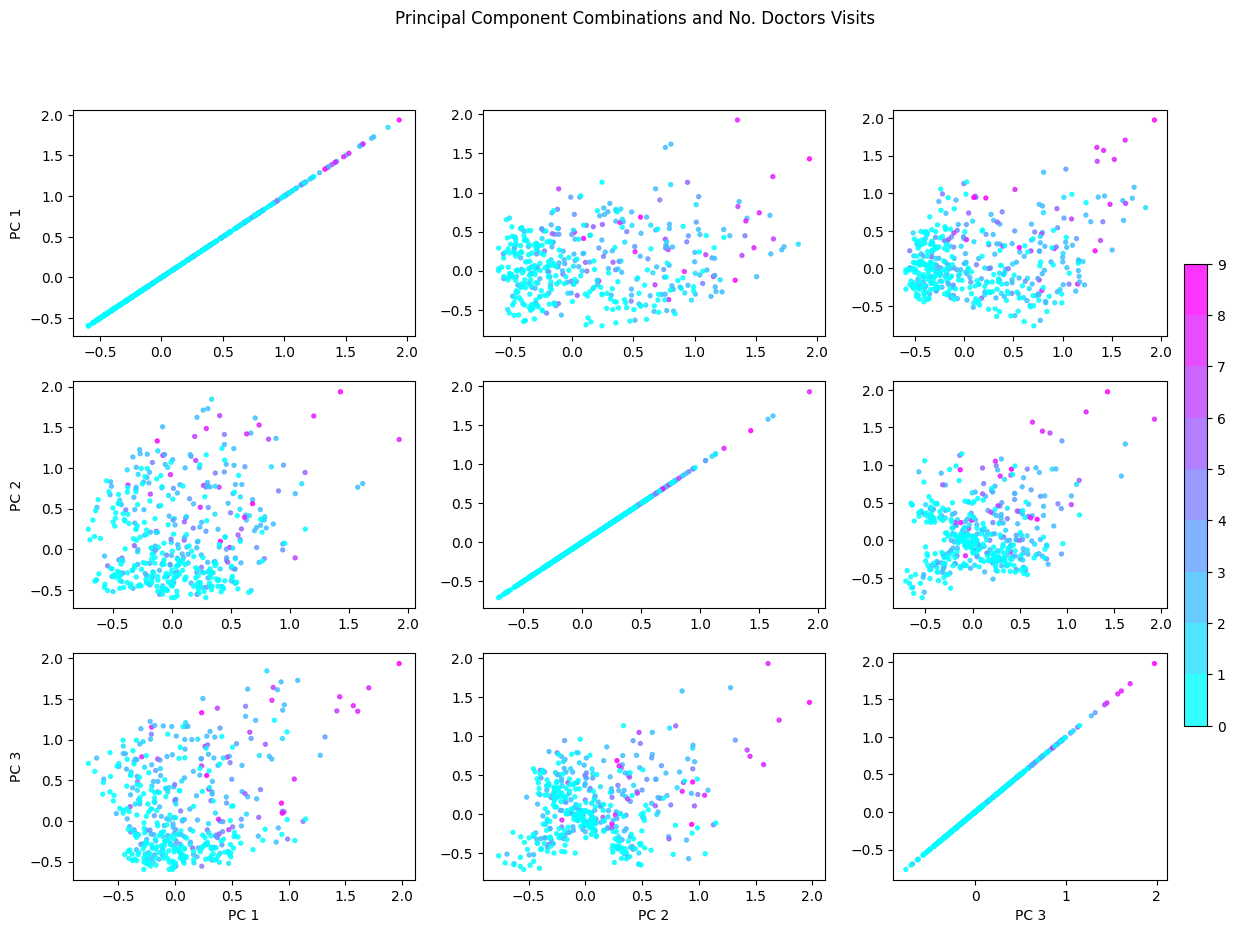

In [55]:
def make_plot(axes, df_, mask, labs, xint, yint):
    return axes[xint, yint].scatter(
        df_[mask,xint], 
        df_[mask,yint], 
        c=labs, 
        alpha=alpha, 
        s=size, 
        cmap=newcmp
    )
    
not_zero = df["doctorco"] > 1
not_zero[::10] = True
not_zero[::4] = False 

combos = [
    (0, 0), (0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1), (2, 2), 
    (1, 1)
]
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
cb = [make_plot(ax, df_mca, not_zero, df['doctorco'][not_zero], x, y) for x, y in combos][0]
ax[0, 0].set_ylabel("PC 1")
ax[1, 0].set_ylabel(f"PC 2")
ax[2, 0].set_ylabel(f"PC 3")
ax[2, 0].set_xlabel(f"PC 1")
ax[2, 1].set_xlabel(f"PC 2")
ax[2, 2].set_xlabel(f"PC 3")
fig.colorbar(cb, ax=ax[:, 2], shrink=0.6)
fig.suptitle("Principal Component Combinations and No. Doctors Visits")
fig.savefig("./mca_pc_comb.png")
pass

What I find interesting about the plot above is that the best separation 
of high numbers of doctors visits (in my opinion) is being done by the 
1st and 3rd principal components. This is contrary to the fact that 
the 1st and 2nd capture more variance in the data.

### 3D Downprojection
Lastly, we can also look at the projection in 3D space.

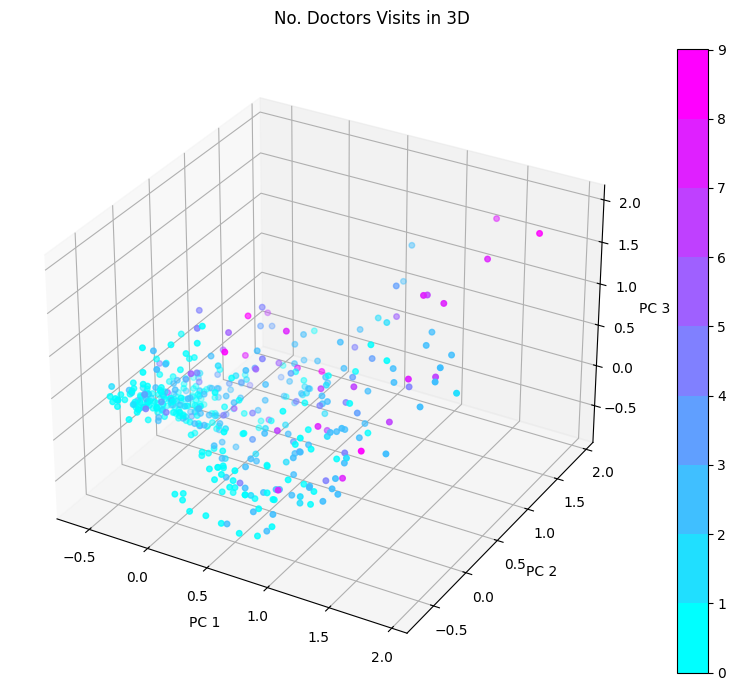

In [56]:
fig = plt.figure(figsize=(9, 7), tight_layout=True)
ax = fig.add_subplot(projection="3d")
cb = ax.scatter(df_mca[not_zero, 0], df_mca[not_zero, 1], df_mca[not_zero, 2], c=df['doctorco'][not_zero], s=size*2, cmap=newcmp)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
fig.suptitle("No. Doctors Visits in 3D")
fig.colorbar(cb)
plt.savefig("./mca_doctorco_3d.png")
pass

In 3D we can clearly see that there do seem to be some clusters in the 
data. However, they don't seem to be strictly related to doctors visits.

### Additional Data Exploration
While looking at doctors visits is interesting, I'd also like to look 
at some other variables. In the following down-projections I've included 
doctors visits in the MCA.
An important note is that I'm no longer under sampling 0's and 1's here.
I'm instead under-sampling the whole dataset by a factor of 2.

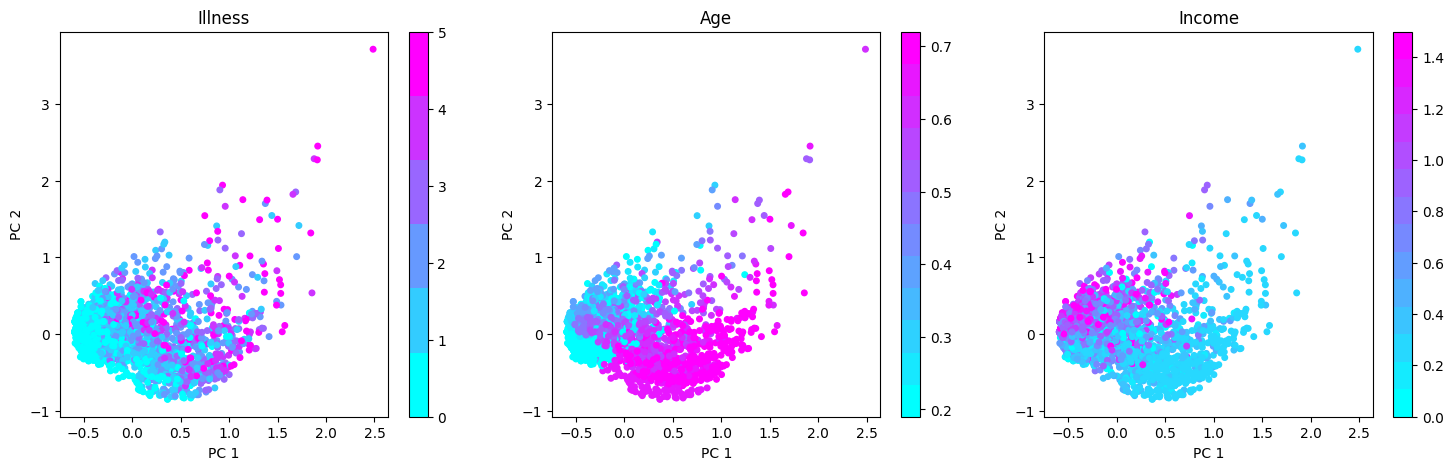

In [57]:
def get_colormap(name: str, no: int):
    hot_ = mpl.colormaps[name].resampled(no)
    newcolors_ = hot_(np.linspace(0, 1, no))
    return mpl.colors.ListedColormap(newcolors_)
    

mca = MCA(
    n_components=142,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
mca = mca.fit(df)
df_mca = mca.row_coordinates(df).to_numpy()

uf = 2

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 3, 1)
cb = ax.scatter(
    df_mca[::uf, 0], df_mca[::uf, 1], 
    c=df['illness'][::uf], 
    s=size*2,
    cmap=get_colormap("cool", len(pd.unique(df['illness'])))
)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_title("Illness")
fig.colorbar(cb)

ax = fig.add_subplot(1, 3, 2)
cb = ax.scatter(
    df_mca[::uf, 0], df_mca[::uf, 1], 
    c=df['age'][::uf], 
    s=size*2,
    cmap=get_colormap("cool", len(pd.unique(df['age'])))
)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_title("Age")
fig.colorbar(cb)

ax = fig.add_subplot(1, 3, 3)
cb = ax.scatter(
    df_mca[::uf, 0], df_mca[::uf, 1], 
    c=df['income'][::uf], 
    s=size*2,
    cmap=get_colormap("cool", len(pd.unique(df['income'])))
)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_title("Income")
fig.colorbar(cb)
plt.savefig("./mca_2d_bunchofstuff.png")
pass

The above plot's give some interesting insight into how illness, age 
and income are related. We can see that the number of illnesses in the 
past 2 weeks is dramatically lower in young people. We can also see that 
Income is much lower in older people. This makes sense as they are 
probably in retirement and are not being paid a full time wage anymore. 
The extreme points that seem like outliers are actually the ones with a 
high number of doctors visits.

### Visualizing Higher Dimensional Clusters
The team has looked at clustering in higher dimensions, and this 
down-projection gives us an opportunity to visualize these clusters.

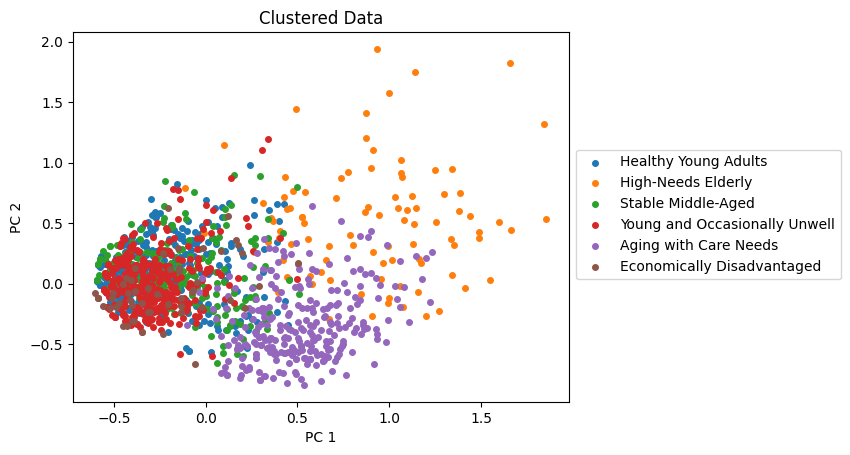

In [58]:
clusters = pd.read_csv("./clustered_data.csv")["cluster"]
all_clusters = []
[all_clusters.append(clusters==i) for i in range(clusters.min(), clusters.max()+1)]
unique_clusters = list(range(clusters.min(), clusters.max()+1))

cluster_labels = [
    "Healthy Young Adults",
    "High-Needs Elderly",
    "Stable Middle-Aged",
    "Young and Occasionally Unwell",
    "Aging with Care Needs",
    "Economically Disadvantaged"
]

uf = 4
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
[ax.scatter(
    df_mca[i][::uf, 0], 
    df_mca[i][::uf, 1], 
    label=k, 
    s=size*2) for j, (i, k) in enumerate(zip(all_clusters, cluster_labels))
]
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_title("Clustered Data")
fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
plt.savefig("./mca_clustering_vis.png", bbox_inches="tight")
pass

Comparing with the previous plot's, it's interesting to be able to 
directly see what kind of information these clusters have captured. For 
example, the "Aging with Care Needs" cluster is exactly on top of where 
the old population is in the dataset. 
This makes a lot of sense and may even be obvious, but it's very 
interesting to be able to visually see it.

We also see that a few clusters are on top of one another. This 
illustrates the fact that our down-projection is inherently losing 
information and is called "overcrowding". We knew this was a problem 
based off of the explained variance presented earlier.
While these clusters may make sense in higher dimensions where there is 
extra variance, they end up overlapping here.

Overcrowding is a common problem with dimensionality reduction, and it 
would be interesting to be able to try some different algorithms like 
t-SNE or ISOMAP, which take some extra measures over PCA to mitigate this 
problem.